In [108]:
from matplotlib import pyplot as plt
from skimage import data

In [97]:
class seam_carver:
    def __init__(self, image):
        #note: image is a just a 2d array of RGB tuples
        self.image = image
        self.width = len(image[0])
        self.height = len(image)
        self.energy_grid = [[None for i in range(self.width)] for j in range(self.height)]
        
    def energy(self, row, col):
        '''calculates energy. energy is defined as $\delta_x^2(x, y) + \delta_y^2(x, y)$
        where $\delta_y(x, y)$ is defined $R_y(x, y) + G_y(x, y) + B_y(x, y)$, where 
        $R_x(x, y) = | (x, y - 1)_{RED} - (x, y + 1)_{RED} |$ and similarly for G, B
        I.e, the energy is high for a pixel between two pixels of vastly different colors
        For edge (haha) cases, just think of the image as a torus (or experiment with other options)'''
        def color_gradient(row, col, direction, color):
            color_to_index = {"R": 0, "G":1, "B":2}
            delta_r, delta_c = 0, 0
            if direction == "H":
                delta_c = 1
            elif direction == "V":
                delta_r = 1
            return abs(self.image[(row - delta_r)%self.height][(col - delta_c)%self.width][color_to_index[color]]
                       - self.image[(row + delta_r)%self.height][(col + delta_c)%self.width][color_to_index[color]])
        energy = 0
        for d in "HV":
            dir_en = 0
            for c in "RGB":
                dir_en += color_gradient(row, col, d, c)**2
            energy += dir_en
        return energy
        
    def create_energy_grid(self):
        #TODO: iterate through image, calculating energy for each pixel
        #store the results in self.energy_grid
        for row in range(self.height):
            for col in range(self.width):
                self.energy_grid[row][col] = self.energy(row, col)
        
    def shortest_path(self):
        #TODO: assert that the image is the same size as the energy grid
        shortest_paths = {}

        def path_val(path):
            return sum([self.energy_grid[row][col] for row, col in path])

        def helper(row, col):
            #if we've already solved this subproblem, just remember it
            if((row, col) in shortest_paths):
                return shortest_paths[(row, col)]
            #if we are at the bottom row, than we are done
            if(row == len(self.energy_grid) - 1):
                shortest_paths[(row, col)] = [(row, col)]
                return [(row, col)]
            shortest_path = None
            #Note: this is the euclidean way to think of this
            #Also note that right now this is just up and down seam carving
            for delta_r, delta_c in [(1, -1), (1, 0), (1, 1)]:
                #if we're going to go off the side, don't
                #note that we don't need to worry about going off the bottom because of the base case
                if(col + delta_c >= self.width or col + delta_c < 0):
                    continue
                cur_path = [(row, col)] + helper(row + delta_r, col + delta_c)
                #if there is no shortest path, or this is shorter, take this route
                if shortest_path is None:
                    shortest_path = cur_path
                elif path_val(shortest_path) > path_val(cur_path):
                    shortest_path = cur_path
            #remember the result and return it
            shortest_paths[(row, col)] = shortest_path
            return shortest_path
        #to find the shortest from top to bottom, we just have to look at each possible starting point
        #percolation!
        return min([helper(0, c) for c in range(self.width)], key = lambda path : path_val(path))
    
    def removeVerticalSeam(self):
        self.create_energy_grid()
        for row, col in self.shortest_path():
            self.image[row].pop(col)
        self.width -= 1

Create a new seam carver with a nice image to experiment on

In [98]:
a = seam_carver(data.coffee().tolist())

Remove 70 pixels from each row

In [104]:
for i in range(70):
    a.removeVerticalSeam()

KeyboardInterrupt: 

The original image

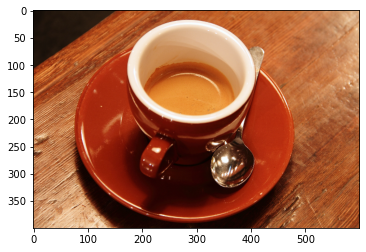

In [100]:
plt.imshow(data.coffee())

The narrower image

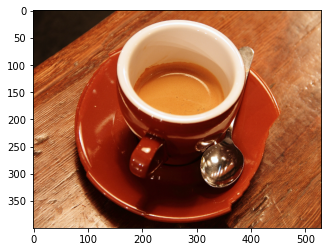

In [105]:
plt.imshow(a.image)

Now has width of 

In [115]:
a.width

530

In [113]:
rocket_seam = seam_carver(data.rocket().tolist())

In [114]:
for i in range(50):
    rocket_seam.removeVerticalSeam()

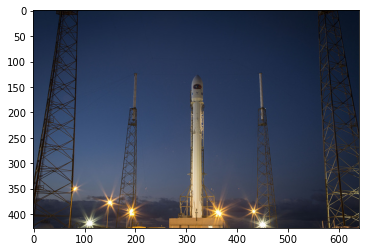

In [116]:
plt.imshow(data.rocket())

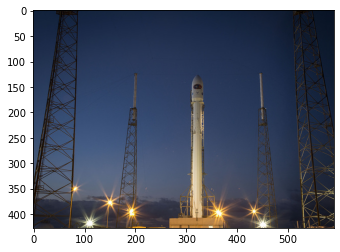

In [117]:
plt.imshow(rocket_seam.image)